In [2]:
import os
import numpy as np
from astropy.io import fits
from tqdm import tqdm
from PIL import Image
import cv2
import pickle
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb

In [3]:
# 测试图输入的是3，256，256 所以有些地方还是用的256 没换成图像
def load_img(filename):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in filename:
        with fits.open(filename) as hdul:
            return hdul[0].data
    elif ".dat" in filename:
        with open(filename, "rb") as f:
            return pickle.load(f)
    else:
        raise TypeError

def normalization(img: np.ndarray, shape: str, lock: bool):
    """
    :param img: CHW和HWC均可
    :param shape: 传入CHW或者HWC，输出同一形式
    :param lock: True时，三通道一起归一化，否则分通道归一化
    :return: 返回CHW或HWC
    """
    def compute(data: np.ndarray):
        h, w = data.shape
        data = data.reshape(-1)
        max = np.max(data)
        min = np.min(data)
        if max == min:
            return 65535    # 防止三通道中有一个通道无信息
        else:
            norm_data = (data - min) / (max - min)
            return norm_data.reshape((h, w))
    if lock:
        original_shape = img.shape
        flatten = img.reshape(-1)
        normalized  = (flatten - flatten.min()) / (flatten.max() - flatten.min())
        return normalized.reshape(original_shape)
    else:
        if shape == "CHW" or shape == "chw":
            g, r, z = img[0], img[1], img[2]
            norm_g, norm_r, norm_z = compute(g), compute(r), compute(z)
            if type(norm_g) == int or  type(norm_r) == int or type(norm_z) == int:
                return 65535
            else:
                return np.array((norm_g, norm_r, norm_z))
        elif shape == "HWC" or shape == "hwc":
            g, r, z = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            norm_g, norm_r, norm_z = compute(g), compute(r), compute(z)
            if type(norm_g) == int or  type(norm_r) == int or type(norm_z) == int:
                return 65535
            else:
                return np.concatenate((norm_g.reshape(256, 256, 1), norm_r.reshape(256, 256, 1), norm_z.reshape(256, 256, 1)), axis=2)
        else:
            raise RuntimeError

def write2fits(data: np.ndarray, filename: str):
    """
    将ndarray保存成fits文件
    :param data: 待保存数据
    :param filename: 保存文件名
    :return:
    """
    if len(data.shape) == 2:
        hdu = fits.PrimaryHDU(data)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(filename)
        hdulist.close()
    elif data.shape[-1] == 3:
        g, r, z = data[:, :, 0], data[:, :, 1], data[:, :, 2]
        data = np.array((g, r, z))
        hdu = fits.PrimaryHDU(data)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(filename)
        hdulist.close()
    elif data.shape[0] == 3:
        hdu = fits.PrimaryHDU(data)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(filename)
        hdulist.close()
    else:
        raise RuntimeError


def color_balance(img: np.ndarray, shape: str, region: str, kernel_size: list=[60, 60]):
    """
    三通道直方图平衡
    :param img: 输入图像，CHW和HWC均可，需要在shape中输入
    :param kernel_size: 核大小，长宽不必相同
    :param shape: 应当为CHW或HWC
    :param region: 全局模式则输入global，否则输入kernel使用中心核模式，无默认大小
    :return: 根据输入shape返回对应形式的ndarray
    """
    if region == "global":
        if shape == "CHW" or shape == "chw":
            r, g, b = img[0], img[1], img[2]
            R, G, B = np.mean(r), np.mean(g), np.mean(b)
            K = (R + G + B) / 3
            Kr, Kg, Kb = K / R, K / G, K / B
            return np.array((Kr * r, Kg * g, Kb * b))
        elif shape == "HWC" or shape == "hwc":
            r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            R, G, B = np.mean(r), np.mean(g), np.mean(b)
            K = (R + G + B) / 3
            Kr, Kg, Kb = K / R, K / G, K / B
            return np.concatenate((Kr * r.reshape(256, 256, 1), Kg * g.reshape(256, 256, 1), Kb * b.reshape(256, 256, 1)),axis=2)
        else:
            raise RuntimeError
    elif region == "kernel":
        h_k, w_k = kernel_size[0], kernel_size[1]   # 核的长宽
        h, w = img[0].shape # 图像长（纵向）宽（横向）
        h_l, h_r = int(h/2) - h_k, int(h/2) + h_k
        w_l, w_r = int(w/2) - w_k, int(w/2) + w_k
        r, g, b = img[0], img[1], img[2]
        r_kernel, g_kernel, b_kernel = img[0, h_l:h_r, w_l: w_r], img[1, h_l:h_r, w_l: w_r], img[2, h_l:h_r, w_l: w_r]
        R, G, B = np.mean(r_kernel), np.mean(g_kernel), np.mean(b_kernel)
        K = (R + G + B) / 3
        Kr, Kg, Kb = K / R, K / G, K / B
        if shape == "CHW" or shape == "chw":
            return np.array((Kr * r, Kg * g, Kb * b))
        elif shape == "HWC" or shape == "hwc":
            return np.concatenate((Kr * r.reshape(256, 256, 1), Kg * g.reshape(256, 256, 1), Kb * b.reshape(256, 256, 1)),axis=2)
        else:
            raise RuntimeError
    else:
        raise RuntimeError


def median_balance(img: np.ndarray, shape: str, region: str, kernel_size: list=[60, 60]):
    """
    三通道直方图平衡
    :param img: 输入图像，CHW和HWC均可，需要在shape中输入
    :param kernel_size: 核大小，长宽不必相同
    :param shape: 应当为CHW或HWC
    :param region: 全局模式则输入global，否则输入kernel使用中心核模式，无默认大小
    :return: 根据输入shape返回对应形式的ndarray
    """
    if region == "global":
        if shape == "CHW" or shape == "chw":
            r, g, b = img[0], img[1], img[2]
            R, G, B = np.median(r), np.median(g), np.median(b)
            K = (R + G + B) / 3
            Kr, Kg, Kb = K / R, K / G, K / B
            return np.array((Kr * r, Kg * g, Kb * b))
        elif shape == "HWC" or shape == "hwc":
            r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            R, G, B = np.median(r), np.median(g), np.median(b)
            K = (R + G + B) / 3
            Kr, Kg, Kb = K / R, K / G, K / B
            return np.concatenate((Kr * r.reshape(256, 256, 1), Kg * g.reshape(256, 256, 1), Kb * b.reshape(256, 256, 1)),axis=2)
        else:
            raise RuntimeError
    elif region == "kernel":
        h_k, w_k = kernel_size[0], kernel_size[1]   # 核的长宽
        h, w = img[0].shape # 图像长（纵向）宽（横向）
        h_l, h_r = int(h/2) - h_k, int(h/2) + h_k
        w_l, w_r = int(w/2) - w_k, int(w/2) + w_k
        r, g, b = img[0], img[1], img[2]
        r_kernel, g_kernel, b_kernel = img[0, h_l:h_r, w_l: w_r], img[1, h_l:h_r, w_l: w_r], img[2, h_l:h_r, w_l: w_r]
        R, G, B = np.median(r_kernel), np.median(g_kernel), np.median(b_kernel)
        K = (R + G + B) / 3
        Kr, Kg, Kb = K / R, K / G, K / B
        if shape == "CHW" or shape == "chw":
            return np.array((Kr * r, Kg * g, Kb * b))
        elif shape == "HWC" or shape == "hwc":
            return np.concatenate((Kr * r.reshape(256, 256, 1), Kg * g.reshape(256, 256, 1), Kb * b.reshape(256, 256, 1)),axis=2)
        else:
            raise RuntimeError
    else:
        raise RuntimeError

def mtf(data: np.ndarray, m: float):
    """
    非线性变换
    :param data: 输入数据
    :param m: midtones值
    :return: 结果
    """
    return((m - 1) * data) / ((2 * m - 1) * data - m)

def rgb2gray(img: np.ndarray, shape: str):
    """
    rgb转灰度图
    :param img: 图像
    :param channel_factor: 三通道权重因子，应为list
    :return:
    """
    return np.dot(img[..., :3], [0.299, 0.587, 0.114])

def channel_cut(gray):
    highlight = 1.
    hist, bar = np.histogram(gray.reshape(-1), bins=65536)
    cdf = hist.cumsum()
    shadow_index = np.argwhere(cdf > 0.001 * gray.reshape(-1).shape[0])[0]
    shadow = bar[shadow_index]
    midtones = np.median(gray) - shadow
    gray[gray < shadow] = shadow
    gray[gray > highlight] = 1.
    gray = gray.reshape(-1)
    norm_data = (gray - gray.min()) / (gray.max() - gray.min())
    gray = norm_data.reshape((256, 256))
    median = np.median(mtf(gray, midtones))
    set_median = 1/8
    weight = median / set_median
    right_midtones = weight * midtones
    return mtf(gray, right_midtones)


def auto_scale(data: np.ndarray):
    g, r, z = channel_cut(data[0]), channel_cut(data[1]), channel_cut(data[2])
    img = np.array((g, r, z))
    img[img < 0] = 0
    img[img > 1] = 1.
    return img


def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)


def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))


/data/renhaoye/decals_2022/in_decals/fits/181.462541_11.317759.fits


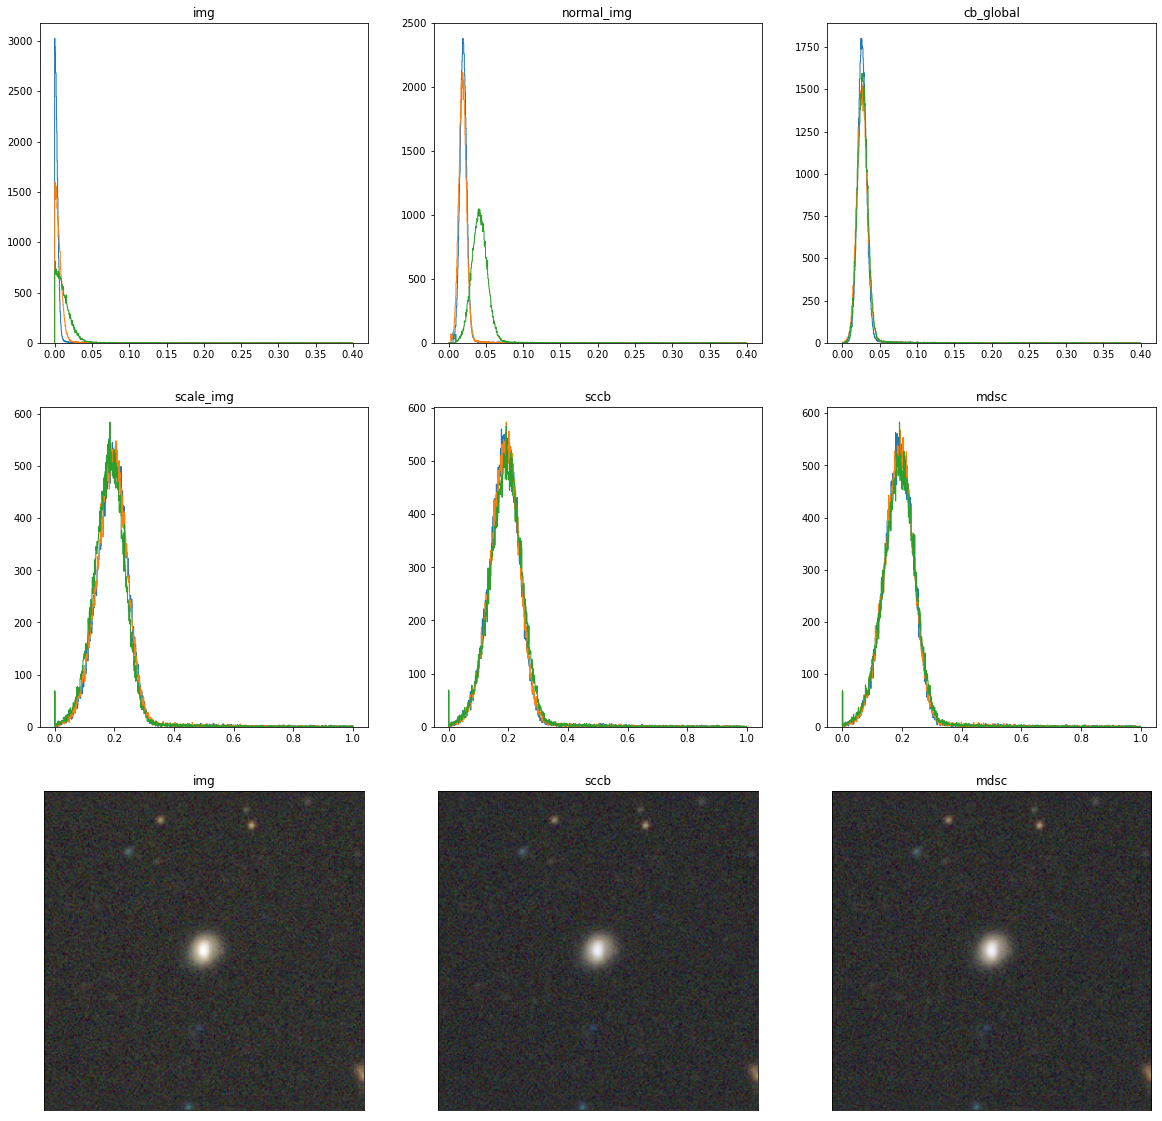

In [4]:
# g, r, z = scale_img[0], scale_img[1], scale_img[2]
path = "/data/renhaoye/decals_2022/in_decals/fits/"
fits_files = os.listdir(path)
test_path = path + fits_files[11]
print(test_path)
img = load_img(test_path)
normal_img_unlock = normalization(img, shape="CHW", lock=False)
normal_img_lock = normalization(normal_img_unlock, shape="CHW", lock=False)
cb_global = color_balance(normal_img_lock, shape="CHW", region="global")
cb_kernel = color_balance(normal_img_lock, kernel_size=[60, 60], region="kernel", shape = "CHW")

scale_img = auto_scale(normal_img_lock)
sccb = color_balance(scale_img, kernel_size=[60, 60], region="kernel", shape = "CHW")
mdsc = median_balance(scale_img, kernel_size=[60, 60], region="kernel", shape = "CHW")
plt.figure(figsize=(20, 20))
max_range = 1000
min = 0
max = 0.4
density = False
plt.subplot(331)
plt.title("img")
g, r, z = img[0], img[1], img[2]
plt.hist(g.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(r.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(z.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")

plt.subplot(332)
plt.title("normal_img")
g, r, z = normal_img_lock[0], normal_img_lock[1], normal_img_lock[2]
plt.hist(g.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(r.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(z.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")

plt.subplot(333)
plt.title("cb_global")
g, r, z = cb_global[0], cb_global[1], cb_global[2]
plt.hist(g.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(r.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(z.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")

plt.subplot(334)
plt.title("scale_img")
max = 1
g, r, z = scale_img[0], scale_img[1], scale_img[2]
plt.hist(g.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(r.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(z.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")

plt.subplot(335)
plt.title("sccb")
g, r, z = sccb[0], sccb[1], sccb[2]
plt.hist(g.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(r.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(z.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")

plt.subplot(336)
plt.title("mdsc")
g, r, z = mdsc[0], mdsc[1], mdsc[2]
plt.hist(g.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(r.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")
plt.hist(z.reshape(-1), bins=max_range, density=density, range=(min, max), histtype="step")

plt.subplot(337)
plt.title("img")
plt.imshow(chw2hwc(scale_img))
plt.xticks([])
plt.yticks([])

plt.subplot(338)
plt.title("sccb")
plt.imshow(chw2hwc(normalization(sccb, shape="CHW", lock=True)))
plt.xticks([])
plt.yticks([])

plt.subplot(339)
plt.title("mdsc")
plt.imshow(chw2hwc(normalization(mdsc, shape="CHW", lock=True)))
plt.xticks([])
plt.yticks([])

plt.show()

# write2fits(mdsc, "/data/renhaoye/mdscc.fits")

In [5]:
plt.figure(figsize=(60, 60))
path = "/data/renhaoye/decals_2022/in_decals/dataset/testSet/7/"
# path = "/data/renhaoye/decals_2022/in_decals/fits/"
fits_files = os.listdir(path)
for i in range(400):
    plt.subplot(20, 20, i + 1)
    img = normalization(load_img(path + fits_files[i]), shape="CHW", lock=False)
    img = normalization(img, shape="CHW", lock=True)
    # img = color_balance(img, shape="CHW", region="kernel")
    scaled = auto_scale(img)
    # plt.imshow(chw2hwc(median_balance(scaled, kernel_size=[60, 60], region="kernel", shape = "CHW")))
    plt.imshow(chw2hwc(scaled))
    # plt.title(i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# 最好的结果：不必用到color_balance和median_balance, 如下顺序做完可以实现前面这两个函数的功能
normalized_unlock = normalization(input_data, shape="CHW", lock=False)    # 先做一次分通道归一化
if not type(normalized_unlock) == int:
    normalized_lock = normalization(normalized_unlock, shape="CHW", lock=True)  # 再做一次全通道归一化
    if not type(normalized_lock) == int:
        scaled = auto_scale(normalized_lock)    # 再做拉伸